In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

Load the data and explore a bit.

In [85]:

forests = pd.read_csv('forests.csv')
print(forests.head())


   temp  humid  wind  rain  FFMC  DMC    DC  ISI  BUI  FWI  region   fire
0    29     57    18   0.0  65.7  3.4   7.6  1.3  3.4  0.5  Bejaia  False
1    29     61    13   1.3  64.4  4.1   7.6  1.0  3.9  0.4  Bejaia  False
2    26     82    22  13.1  47.1  2.5   7.1  0.3  2.7  0.1  Bejaia  False
3    25     89    13   2.5  28.6  1.3   6.9  0.0  1.7  0.0  Bejaia  False
4    27     77    16   0.0  64.8  3.0  14.2  1.2  3.9  0.5  Bejaia  False


In [86]:
forests.describe

<bound method NDFrame.describe of      temp  humid  wind  rain  FFMC   DMC    DC  ISI   BUI  FWI  \
0      29     57    18   0.0  65.7   3.4   7.6  1.3   3.4  0.5   
1      29     61    13   1.3  64.4   4.1   7.6  1.0   3.9  0.4   
2      26     82    22  13.1  47.1   2.5   7.1  0.3   2.7  0.1   
3      25     89    13   2.5  28.6   1.3   6.9  0.0   1.7  0.0   
4      27     77    16   0.0  64.8   3.0  14.2  1.2   3.9  0.5   
..    ...    ...   ...   ...   ...   ...   ...  ...   ...  ...   
238    30     65    14   0.0  85.4  16.0  44.5  4.5  16.9  6.5   
239    28     87    15   4.4  41.1   6.5   8.0  0.1   6.2  0.0   
240    27     87    29   0.5  45.9   3.5   7.9  0.4   3.4  0.2   
241    24     54    18   0.1  79.7   4.3  15.2  1.7   5.1  0.7   
242    24     64    15   0.2  67.3   3.8  16.5  1.2   4.8  0.5   

             region   fire  
0            Bejaia  False  
1            Bejaia  False  
2            Bejaia  False  
3            Bejaia  False  
4            Bejaia  False  

In [87]:
forests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    243 non-null    int64  
 1   humid   243 non-null    int64  
 2   wind    243 non-null    int64  
 3   rain    243 non-null    float64
 4   FFMC    243 non-null    float64
 5   DMC     243 non-null    float64
 6   DC      243 non-null    float64
 7   ISI     243 non-null    float64
 8   BUI     243 non-null    float64
 9   FWI     243 non-null    float64
 10  region  243 non-null    object 
 11  fire    243 non-null    bool   
dtypes: bool(1), float64(7), int64(3), object(1)
memory usage: 20.2+ KB


We want to check the multicollinearity assumption before we get started. Let's create a table of correlations for the quantitative variables in forests and then plot the correlations with a heat map to look for potential collinear variables.

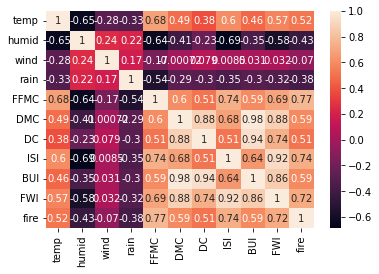

<Figure size 432x288 with 0 Axes>

In [88]:
correl_grid = forests.corr()
sns.heatmap(correl_grid, xticklabels=correl_grid.columns,yticklabels= correl_grid.columns,  annot=True)
plt.show()
plt.clf()



The following have correlations > 0.9:

- DMC and BUI
- DC and BUI
- FWI and ISI


Let’s explore the relationship between relative humidity (*humid*) and maximum temperature (*temp*) by creating a scatter plot.

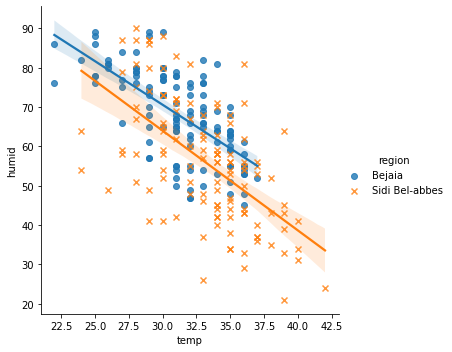

<Figure size 432x288 with 0 Axes>

In [89]:
sns.lmplot(x='temp', y='humid', data=forests, hue='region', legend=True, markers=['o', 'x'])
plt.show()
plt.clf()



Fit a multiple linear regression model predicting humidity with temperature and region as predictors.

In [90]:
modelH = sm.OLS.from_formula('humid ~ temp + region', forests).fit()
print(modelH.params)

Intercept                   142.575801
region[T.Sidi Bel-abbes]     -7.247538
temp                         -2.392547
dtype: float64


Equations

Full equation:

humid = 142.6 - 2.4 * temp - 7.2 * region (0 for Bejaia,1 for Sidi Bel-abbes)

For Bejaia:

humid = 142.6 - 2.4 * temp

For Sidi Bel-abbes:

humid = 135.3 - 2.4 * temp


- Holding region constant, the coefficient on temperature indicates that for every temperature increase of one-degree Celsius, relative humidity decreases by 2.4%. 
For Bejaia equation:

- The intercept indicates that a temperature of zero degrees Celsius is associated with an average relative humidity of 142.6%. (This interpretation is doesn't make sense as relative humidity can't go past 100% and 0 degrees C is far below the temperatures available in our dataset, but we learn the regression line starts higher for Bejaia.)

For Sidi Bel-abbes equation:
- The intercept indicates that a temperature of zero degrees Celsius is associated with an average relative humidity of 135.3%. (This interpretation is doesn't make sense as relative humidity can't go past 100% and 0 degrees C is far below the temperatures available in our dataset, but we learn the regression line starts lower for Sidi Bel-abbes.)


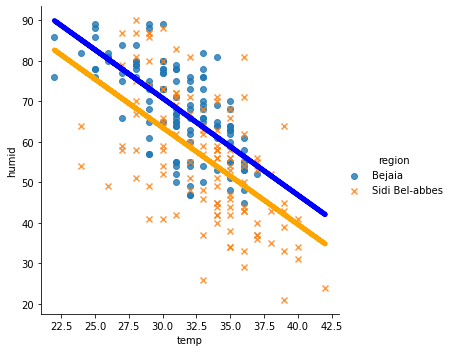

<Figure size 432x288 with 0 Axes>

In [91]:
#plot regression lines
sns.lmplot(x='temp', y='humid', data=forests, hue='region', legend=True, markers=['o', 'x'], fit_reg=False)
plt.plot(forests.temp, modelH.params[0]+modelH.params[1]*0+modelH.params[2]*forests.temp, color='blue',linewidth=5, label='Bejaia')
plt.plot(forests.temp, modelH.params[0]+modelH.params[1]*1+modelH.params[2]*forests.temp, color='orange',linewidth=5, label='Sidi Bel-abbes')
plt.show()
plt.clf()


We now will fit the first of two regression models predicting the Fine Fuel Moisture Code (*FFMC*), a measurement of fuel moisture that contributes to the assessment of fire risk. First, let’s explore the relationship between *FFMC* and temperature and see if that relationship looks different for areas that ended up experiencing a fire compared to those that didn’t.

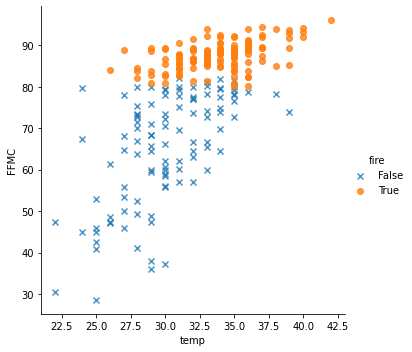

<Figure size 432x288 with 0 Axes>

In [92]:
#plot FFMC vs temperature
sns.lmplot(x='temp', y='FFMC', data=forests, hue='fire', markers=['x', 'o'], fit_reg=False)
plt.show()
plt.clf()

In [93]:
#model predicting FFMC with interaction
resultsF = sm.OLS.from_formula('FFMC ~ temp + fire + temp:fire', data=forests).fit()
print(resultsF.params)

Intercept            -8.108891
fire[T.True]         76.788000
temp                  2.445159
temp:fire[T.True]    -1.887219
dtype: float64


**Full equation:**

FFMC = -8.1 + 2.4 * temp + 76.8 * fire - 1.9 * temp * fire

**For locations without fire:**

no_fire_FFMC = -8.1 +2.4 * temp

**For locations with fire:**

fire_FFMC = -8.1 + 2.4 * temp + 76.8 * 1-1.9 * temp * 1

**Siplified**

fire_FFMC = 68.7 + 0.5 * temp

**Interpretations**

For locations without fire:

FFMC = -8.1 + 2.4*temp

- For every temperature increase of one degree Celsius, FFMC score increases by 2.4 points. 
  
For locations with fire:

FFMC = 68.7 + 0.5*temp

- The regression line has an intercept 76.8 points greater and a slope 1.9 points less than those of the locations that did not end up experiencing a fire. 
- For every temperature increase of one degree Celsius, FFMC score increases by 0.5 points.

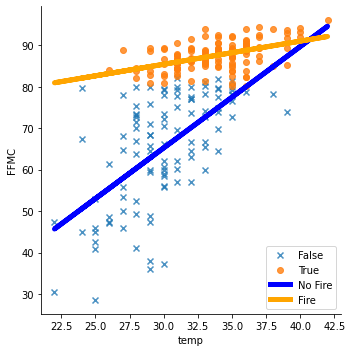

<Figure size 432x288 with 0 Axes>

In [94]:
#plot regression lines
sns.lmplot(x='temp', y='FFMC', data=forests, hue='fire', markers=['x', 'o'], legend= False, fit_reg=False)
plt.plot(forests.temp, resultsF.params[0]+resultsF.params[1]*0+resultsF.params[2]*forests.temp + resultsF.params[3]*forests.temp*0, color='blue',linewidth=5, label='No Fire')
plt.plot(forests.temp, resultsF.params[0]+resultsF.params[1]*1+resultsF.params[2]*forests.temp + resultsF.params[3]*forests.temp*1, color='orange',linewidth=5, label='Fire')
plt.legend()
plt.show()
plt.clf()

Let’s try predicting FFMC from just relative humidity. First, let’s get an idea of what the relationship looks like in a scatter plot.

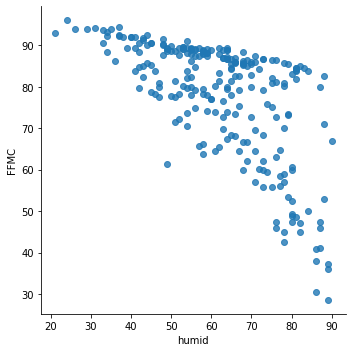

<Figure size 432x288 with 0 Axes>

In [95]:
#plot FFMC vs humid
sns.lmplot(x='humid', y='FFMC', data=forests, fit_reg=False)
plt.show()
plt.clf()

Since we see a curve in the pattern of points on the plot, we will run a multiple regression model.

In [96]:
#polynomial model predicting FFMC
resultsP = sm.OLS.from_formula('FFMC ~ humid + np.power(humid,2)', data=forests).fit()
print(resultsP.params)

#regression equation
# FFMC = 77.63 + 0.75*humid - 0.01*humid^2

Intercept             77.634041
humid                  0.752165
np.power(humid, 2)    -0.011420
dtype: float64


Let's find the FFMC for the following relative humidity levels: 25%, 35%, 60% and 70%.

In [97]:
y_25=resultsP.params[0]+resultsP.params[1]*25+resultsP.params[2]*np.power(25,2)
y_35=resultsP.params[0]+resultsP.params[1]*35+resultsP.params[2]*np.power(35,2)
y_60=resultsP.params[0]+resultsP.params[1]*60+resultsP.params[2]*np.power(60,2)
y_70=resultsP.params[0]+resultsP.params[1]*70+resultsP.params[2]*np.power(70,2)
print(y_25)
print(y_35)
print(y_60)
print(y_70)

89.3007509713196
89.97048469230951
81.65244328464425
74.32827643752216


Interpretation of relationship

- For lower humidity levels, increases in relative humidity are associated with very small increases in FFMC score, until about 35% relative humidity. After this point increases in humidity are associated with increasingly bigger decreases in FFMC score.

Here, we’ve used weather, location, and fire status variables to predict humidity and a measure of forest fuel moisture. There are still more variable to explore but these were good practice for multiple linear regression.